In [1]:
from prophet import Prophet
import xgboost as xgb

import sys, os, yaml, ta
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

import yfinance as yf
from dateutil.relativedelta import relativedelta

from stock_forecast_module import *

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

/Users/truongnguyen/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# Load inputs from inputs.yml
with open('inputs.yml', 'r') as file:
    inputs = yaml.safe_load(file)

# Access specific inputs
start_dt = inputs['params']['start_dt']
split_dt = inputs['params']['split_dt']
real_fc_start_dt = datetime.today().date().strftime('%Y-%m-%d') # inputs['params']['real_fc_start_dt']
real_fc_end_dt = inputs['params']['real_fc_end_dt']
stock_sticker = inputs['params']['stock_sticker']

print(f"Stock sticker: {stock_sticker}")
print(f"Start date: {start_dt}")
print(f"Split date: {split_dt}")
print(f"Real forecast start date: {real_fc_start_dt}")
print(f"Real forecast end date: {real_fc_end_dt}")

Stock sticker: TSLA
Start date: 2018-01-01
Split date: 2025-03-01
Real forecast start date: 2025-05-02
Real forecast end date: 2025-08-15


In [3]:
# Download SP500, NASDAQ, and VIX data
today_date = datetime.today().date()

sp500_data = yf.download('^GSPC',   start=start_dt, end=today_date.strftime('%Y-%m-%d'))
nasdaq_data = yf.download('^IXIC',  start=start_dt, end=today_date.strftime('%Y-%m-%d'))
vix_data = yf.download('^VIX',      start=start_dt, end=today_date.strftime('%Y-%m-%d'))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# Download AAPL, NVDA, and MSFT stock price data
aapl_data = yf.download('AAPL', start=start_dt, end=today_date.strftime('%Y-%m-%d'))
nvda_data = yf.download('NVDA', start=start_dt, end=today_date.strftime('%Y-%m-%d'))
msft_data = yf.download('MSFT', start=start_dt, end=today_date.strftime('%Y-%m-%d'))

display(aapl_data.head())
display(aapl_data.tail())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-01-02,40.479836,40.489237,39.774858,39.986353,102223600
2018-01-03,40.472794,41.017978,40.409348,40.543292,118071600
2018-01-04,40.660789,40.764187,40.437547,40.545642,89738400
2018-01-05,41.123722,41.210668,40.665487,40.757134,94640000
2018-01-08,40.970978,41.267067,40.872278,40.970978,82271200


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-04-25,209.279999,209.750000,206.199997,206.369995,38222300
2025-04-28,210.139999,211.500000,207.460007,210.000000,38743100
2025-04-29,211.210007,212.240005,208.369995,208.690002,36827600
2025-04-30,212.500000,213.580002,206.669998,209.300003,52286500
2025-05-01,213.320007,214.559998,208.899994,209.080002,56391200


In [5]:
stock_data, stocks_indicator_features = import_stock_data(stock_sticker, start_dt)
display(stock_data.head())
display(stock_data.tail())

[*********************100%***********************]  1 of 1 completed


,Date,Close_TSLA,High_TSLA,Low_TSLA,Open_TSLA,Volume_TSLA,RSI,MACD,EMA_9_of_MACD,BB_High,BB_Low,SMA_20,MA_30
0,2018-01-02,21.368668,21.474001,20.733334,20.799999,65283000,49.683740,0.015227,0.158966,23.210638,19.928161,21.569400,21.328555
1,2018-01-03,21.150000,21.683332,21.036667,21.400000,67822500,47.306395,-0.007190,0.125734,23.166286,20.052848,21.609567,21.333444
2,2018-01-04,20.974667,21.236668,20.378668,20.858000,149194500,45.429338,-0.038659,0.092856,23.104457,20.187476,21.645967,21.346511
3,2018-01-05,21.105333,21.149332,20.799999,21.108000,68868000,47.113517,-0.052449,0.063795,23.095450,20.218616,21.657033,21.343778
4,2018-01-08,22.427334,22.468000,21.033333,21.066668,147891000,60.422129,0.042803,0.059596,23.153299,20.328568,21.740933,21.396689


,Date,Close_TSLA,High_TSLA,Low_TSLA,Open_TSLA,Volume_TSLA,RSI,MACD,EMA_9_of_MACD,BB_High,BB_Low,SMA_20,MA_30
1838,2025-04-25,284.950012,286.850006,259.630005,261.690002,167560700,58.134886,-3.939662,-8.392631,286.609039,219.665963,253.137501,253.620001
1839,2025-04-28,285.880005,294.859985,272.420013,288.980011,151731800,58.374009,-1.107777,-6.935661,290.421499,218.086504,254.254002,254.816668
1840,2025-04-29,292.029999,293.320007,279.470001,285.500000,108906600,60.001041,1.614158,-5.225697,295.619975,216.175027,255.897501,256.617335
1841,2025-04-30,282.160004,284.450012,270.779999,279.899994,128961100,56.204160,2.940983,-3.592361,297.599311,215.565693,256.582502,258.512335
1842,2025-05-01,280.519989,290.869995,279.809998,280.010010,99122500,55.574853,3.816176,-2.110654,297.212085,215.728916,256.470501,260.001001


In [6]:
### DATA PREPROCESSING & FEATURE ENGINEERING ###

df, exo_vars = preprocess_data(stock_data, 
                               stocks_additional_features=stocks_indicator_features, 
                               sticker=stock_sticker)

# get stock market data (SP500, NASDAQ, VIX)
df_market = clean_market_data(sp500_data, nasdaq_data, vix_data)
df = df.merge(df_market, on='ds', how='left')
# add market data columns to exogeneous variables
df_market_cols = df_market.columns.tolist()
df_market_cols.remove('ds')  # Remove 'ds' from the list of market columns
exo_vars.extend(df_market_cols)

# get tech stocks data (AAPL, NVDA, MSFT)
df_tech = clean_tech_stocks_data(aapl_data, nvda_data, msft_data)
df = df.merge(df_tech, on='ds', how='left')
# add market data columns to exogeneous variables
df_tech_cols = df_tech.columns.tolist()
df_tech_cols.remove('ds')  # Remove 'ds' from the list of market columns
exo_vars.extend(df_tech_cols)

# get earnings dates (might be helpfull for training/predictions - Right now, not used)
df_earnings, eps_cols = get_earnings_dates(sticker=stock_sticker)
df = df.merge(df_earnings, on='ds', how='left')

# get federal reserve data
df, exo_vars = get_federal_reserve_data(df, exo_vars, start_date=start_dt)

# get daily news sentiment data
df_news_sentiment, exo_vars = extract_historical_news_sentiment(exo_vars, folder_path="gdelt_news_sentiment")
df = df.merge(df_news_sentiment, on='ds', how='left')

# create train and test sets from overall dataset
df, df_train, df_test = create_train_test_sets(df, split_date=split_dt, start_date=start_dt)

print("using exogeneous features:", exo_vars)



### MODEL TRAINING AND FORECASTING ###

# Train Prophet model
prophet_model = train_prophet_model(df_train, exo_vars)
# Make forecast using Prophet model on training data and compute residuals: r = y - y_hat
forecast = make_prophet_forecast(df, prophet_model)
df_residuals = create_residuals(df_train, forecast, exo_vars, eps_cols)
# Train XGBoost model on residuals
xgb_model = train_xgb_model(df_residuals, exo_vars, eps_cols)
# Make predictions using the trained models y_final = y_hat + residuals
# Here, we assume we have future data for exogeneous variables in df_test
df_results = make_predictions(df_residuals, df, df_test, prophet_model, xgb_model, exo_vars, eps_cols, split_date=split_dt)

/Users/truongnguyen/Desktop/U_of_L_MSCS/truongbnguyen88_github_repos/stocks_forecasting/stocks_forecasting/stock_forecast_module.py:401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y_lag1'] = df_train['y'].shift(1)
/Users/truongnguyen/Desktop/U_of_L_MSCS/truongbnguyen88_github_repos/stocks_forecasting/stocks_forecasting/stock_forecast_module.py:402: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y_lag2'] = df_train['y'].shift(2)
/Users/truongnguyen/Desktop/U_of_L_MSCS/truongbnguyen88_gi

using exogeneous features: ['high_value', 'low_value', 'open_value', 'volume_value', 'RSI', 'MACD', 'BB_High', 'BB_Low', 'SMA_20', 'EMA_9_of_MACD', 'MA_30', 'sp500_close', 'sp500_volume', 'nasdaq_close', 'nasdaq_volume', 'vix_close', 'aapl_close', 'aapl_volume', 'nvda_close', 'nvda_volume', 'msft_close', 'msft_volume', 'cpi', 'unemployment_rate', 'interest_rate', 'umcsent', 'gdp_growth', 'mortgage_rate', 'SentimentScore']


08:28:06 - cmdstanpy - INFO - Chain [1] done processing


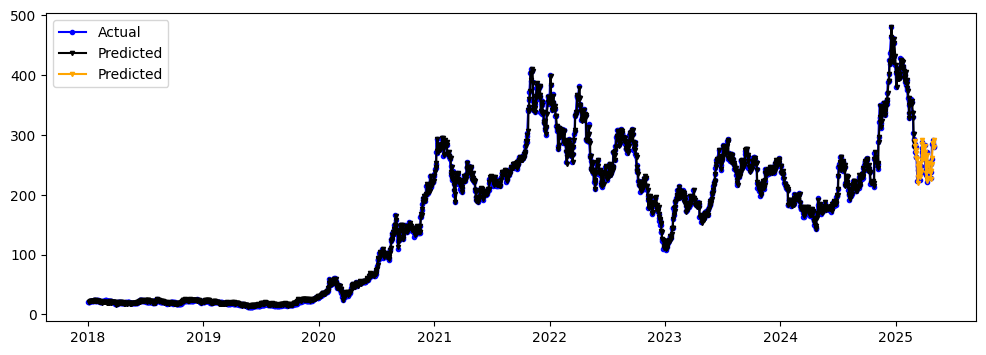

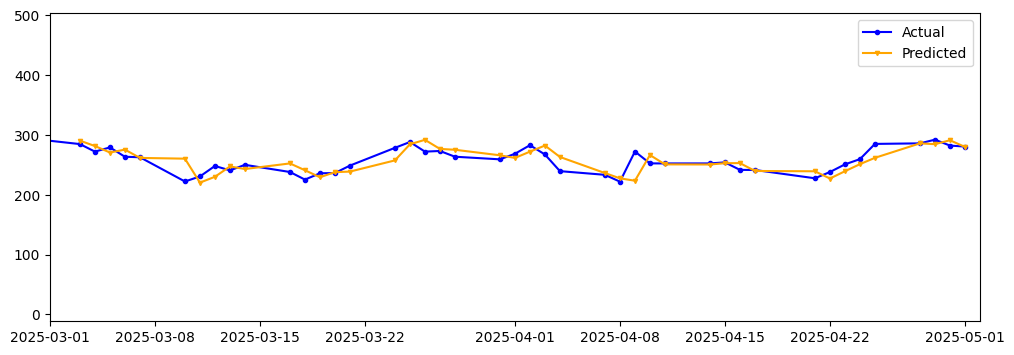

In [7]:
### PLOTTING RESULTS ###

df1 = forecast[forecast['ds'] < '2025-03-01'].copy(deep=True)

fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(df['ds'],           df['y'],              label='Actual',    color='blue',   marker='o', markersize=3)
plt.plot(df1['ds'],          df1['yhat'],             label='Predicted', color='black',   marker='v', markersize=3)
plt.plot(df_results['ds'],   df_results['preds'],  label='Predicted', color='orange', marker='v', markersize=3)
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(df['ds'],           df['y'],              label='Actual',    color='blue',   marker='o', markersize=3)
plt.plot(df_results['ds'],   df_results['preds'],  label='Predicted', color='orange', marker='v', markersize=3)
plt.xlim(pd.to_datetime(split_dt), pd.to_datetime(today_date))
plt.legend()
plt.show()

In [8]:
# Predict future exogeneous variables at future dates since in practice we don't have them available
# This is a mock way to simulate future exogenous variables
df_exo_vars_forecast = predict_future_exo_vars(df_train, df_test, exo_vars, lag_vars=['y_lag1','y_lag2'])
display(df_exo_vars_forecast.head())
# once we roughly-forecast future exogenous variables, we can use them to predict future stock prices
forecast = predict_with_unk_future_exo_vars(df_exo_vars_forecast, df_train, df_test, 
                                            prophet_model, xgb_model, 
                                            exo_vars, eps_cols, lag_vars=['y_lag1','y_lag2'],
                                            split_date=split_dt)

08:28:07 - cmdstanpy - INFO - Chain [1] start processing


['high_value', 'low_value', 'open_value', 'volume_value', 'RSI', 'MACD', 'BB_High', 'BB_Low', 'SMA_20', 'EMA_9_of_MACD', 'MA_30', 'sp500_close', 'sp500_volume', 'nasdaq_close', 'nasdaq_volume', 'vix_close', 'aapl_close', 'aapl_volume', 'nvda_close', 'nvda_volume', 'msft_close', 'msft_volume', 'cpi', 'unemployment_rate', 'interest_rate', 'umcsent', 'gdp_growth', 'mortgage_rate', 'SentimentScore']
high_value


08:28:07 - cmdstanpy - INFO - Chain [1] done processing
08:28:08 - cmdstanpy - INFO - Chain [1] start processing
08:28:08 - cmdstanpy - INFO - Chain [1] done processing


low_value


08:28:08 - cmdstanpy - INFO - Chain [1] start processing


open_value


08:28:08 - cmdstanpy - INFO - Chain [1] done processing
08:28:08 - cmdstanpy - INFO - Chain [1] start processing
08:28:08 - cmdstanpy - INFO - Chain [1] done processing


volume_value


08:28:09 - cmdstanpy - INFO - Chain [1] start processing
08:28:09 - cmdstanpy - INFO - Chain [1] done processing


RSI


08:28:09 - cmdstanpy - INFO - Chain [1] start processing
08:28:09 - cmdstanpy - INFO - Chain [1] done processing


MACD


08:28:09 - cmdstanpy - INFO - Chain [1] start processing


BB_High


08:28:10 - cmdstanpy - INFO - Chain [1] done processing
08:28:10 - cmdstanpy - INFO - Chain [1] start processing


BB_Low


08:28:10 - cmdstanpy - INFO - Chain [1] done processing
08:28:10 - cmdstanpy - INFO - Chain [1] start processing


SMA_20


08:28:10 - cmdstanpy - INFO - Chain [1] done processing
08:28:11 - cmdstanpy - INFO - Chain [1] start processing
08:28:11 - cmdstanpy - INFO - Chain [1] done processing


EMA_9_of_MACD


08:28:11 - cmdstanpy - INFO - Chain [1] start processing


MA_30


08:28:11 - cmdstanpy - INFO - Chain [1] done processing
08:28:12 - cmdstanpy - INFO - Chain [1] start processing


sp500_close


08:28:12 - cmdstanpy - INFO - Chain [1] done processing
08:28:12 - cmdstanpy - INFO - Chain [1] start processing


sp500_volume


08:28:12 - cmdstanpy - INFO - Chain [1] done processing
08:28:13 - cmdstanpy - INFO - Chain [1] start processing


nasdaq_close


08:28:13 - cmdstanpy - INFO - Chain [1] done processing
08:28:13 - cmdstanpy - INFO - Chain [1] start processing


nasdaq_volume


08:28:13 - cmdstanpy - INFO - Chain [1] done processing
08:28:14 - cmdstanpy - INFO - Chain [1] start processing


vix_close


08:28:14 - cmdstanpy - INFO - Chain [1] done processing
08:28:14 - cmdstanpy - INFO - Chain [1] start processing


aapl_close


08:28:14 - cmdstanpy - INFO - Chain [1] done processing
08:28:15 - cmdstanpy - INFO - Chain [1] start processing


aapl_volume


08:28:15 - cmdstanpy - INFO - Chain [1] done processing
08:28:15 - cmdstanpy - INFO - Chain [1] start processing


nvda_close


08:28:15 - cmdstanpy - INFO - Chain [1] done processing
08:28:16 - cmdstanpy - INFO - Chain [1] start processing


nvda_volume


08:28:16 - cmdstanpy - INFO - Chain [1] done processing
08:28:16 - cmdstanpy - INFO - Chain [1] start processing


msft_close


08:28:16 - cmdstanpy - INFO - Chain [1] done processing
08:28:17 - cmdstanpy - INFO - Chain [1] start processing
08:28:17 - cmdstanpy - INFO - Chain [1] done processing


msft_volume


08:28:17 - cmdstanpy - INFO - Chain [1] start processing


cpi


08:28:18 - cmdstanpy - INFO - Chain [1] done processing
08:28:18 - cmdstanpy - INFO - Chain [1] start processing


unemployment_rate


08:28:19 - cmdstanpy - INFO - Chain [1] done processing
08:28:19 - cmdstanpy - INFO - Chain [1] start processing


interest_rate


08:28:20 - cmdstanpy - INFO - Chain [1] done processing
08:28:20 - cmdstanpy - INFO - Chain [1] start processing


umcsent


08:28:20 - cmdstanpy - INFO - Chain [1] done processing
08:28:21 - cmdstanpy - INFO - Chain [1] start processing
08:28:21 - cmdstanpy - INFO - Chain [1] done processing


gdp_growth


08:28:21 - cmdstanpy - INFO - Chain [1] start processing


mortgage_rate


08:28:21 - cmdstanpy - INFO - Chain [1] done processing
08:28:21 - cmdstanpy - INFO - Chain [1] start processing
08:28:22 - cmdstanpy - INFO - Chain [1] done processing


SentimentScore


08:28:22 - cmdstanpy - INFO - Chain [1] start processing


y_lag1


08:28:22 - cmdstanpy - INFO - Chain [1] done processing
08:28:22 - cmdstanpy - INFO - Chain [1] start processing


y_lag2


08:28:22 - cmdstanpy - INFO - Chain [1] done processing


,ds,high_value,low_value,open_value,volume_value,RSI,MACD,BB_High,BB_Low,SMA_20,EMA_9_of_MACD,MA_30,sp500_close,sp500_volume,nasdaq_close,nasdaq_volume,vix_close,aapl_close,aapl_volume,nvda_close,nvda_volume,msft_close,msft_volume,cpi,unemployment_rate,interest_rate,umcsent,gdp_growth,mortgage_rate,SentimentScore,y_lag1,y_lag2,eps_estimate,reported_eps,surprise_pct
0,2018-01-04,47.966549,45.824546,48.612424,111.043813,51.157428,1.082820,55.281723,37.563329,46.507994,1.464480,45.999474,2700.958827,8.012331,7217.916341,7.623487,14.347644,46.886883,4.781054,4.406278,6.071776,76.802107,3.226626,248.873203,4.019431,1.380787,100.083272,1.885412,4.133888,-1.325617,47.619764,48.543242,NaN,NaN,NaN
1,2018-01-05,47.297965,45.713598,48.016952,109.605741,50.924231,0.964894,55.373866,37.655748,46.601627,1.351250,46.245547,2702.600582,8.031242,7214.812352,7.625385,13.900659,46.600420,4.858363,4.310090,6.082801,76.643484,3.272061,248.889345,4.021127,1.381799,100.043530,1.770250,4.140599,-1.418204,47.094758,48.590098,NaN,NaN,NaN
2,2018-01-08,48.228617,45.903972,48.072080,113.750551,52.299356,0.942283,54.385710,38.335909,46.452734,1.245450,46.422898,2706.144113,8.019583,7216.593515,7.600550,14.059692,45.784883,4.800457,4.329067,6.094659,76.175518,3.222351,248.935299,4.022986,1.387064,99.908376,1.822057,4.154046,-1.325207,46.855237,48.039765,NaN,NaN,NaN
3,2018-01-09,47.661276,45.675574,48.279875,110.867678,52.214406,0.782454,53.499899,38.137520,45.932881,1.042222,46.083655,2708.534370,8.061837,7222.319049,7.628179,13.829094,45.554289,4.780166,4.230472,6.090424,76.109765,3.260705,248.956387,4.023530,1.388194,99.908349,1.747795,4.158053,-1.305867,47.117793,47.183941,NaN,NaN,NaN
4,2018-01-10,47.161441,45.357529,47.691374,109.611237,52.317122,0.666549,52.772236,38.200945,45.605227,0.900827,45.906359,2708.577792,8.088779,7217.022694,7.646238,13.739829,45.187394,4.779388,4.167973,6.113573,76.452959,3.304837,248.965567,4.025598,1.390501,99.833455,1.771497,4.159104,-1.281842,46.683047,47.745099,NaN,NaN,NaN


Using the following exogeneous variables:  ['high_value', 'low_value', 'open_value', 'volume_value', 'RSI', 'MACD', 'BB_High', 'BB_Low', 'SMA_20', 'EMA_9_of_MACD', 'MA_30', 'sp500_close', 'sp500_volume', 'nasdaq_close', 'nasdaq_volume', 'vix_close', 'aapl_close', 'aapl_volume', 'nvda_close', 'nvda_volume', 'msft_close', 'msft_volume', 'cpi', 'unemployment_rate', 'interest_rate', 'umcsent', 'gdp_growth', 'mortgage_rate', 'SentimentScore']


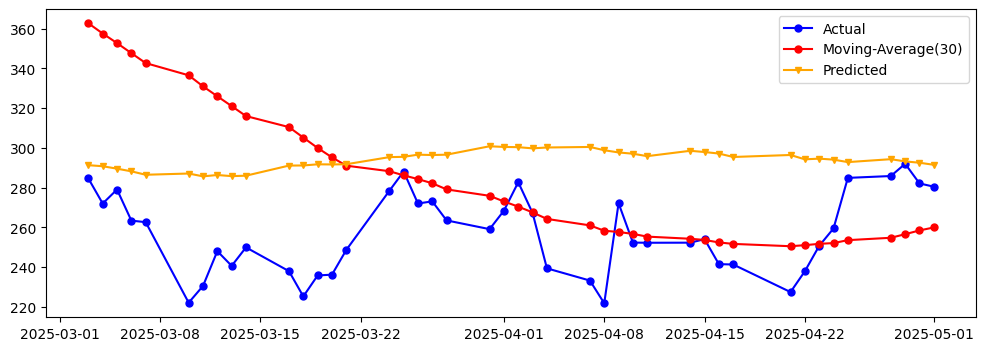

MAPE Score: 4.20%
RMSE Score: 14.29
MAE  Score: 10.68
high_value


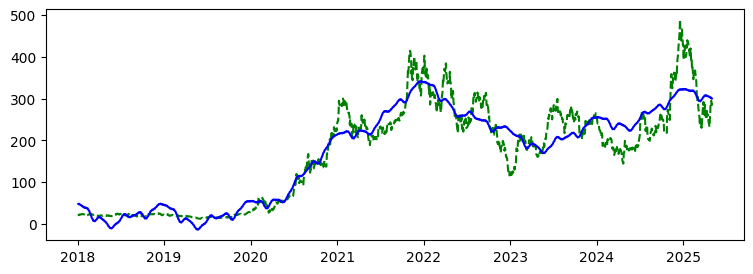

low_value


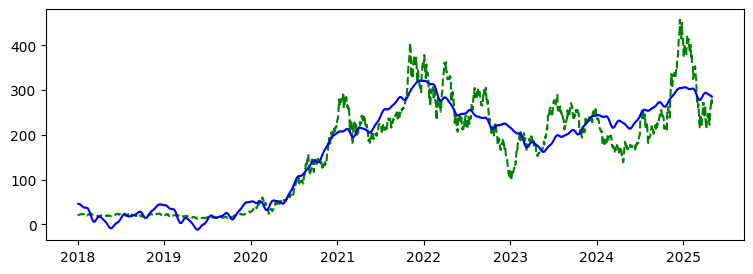

open_value


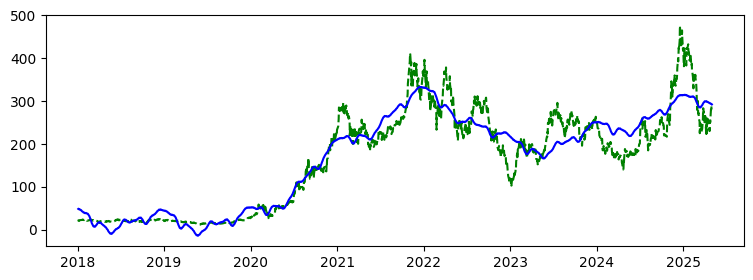

volume_value


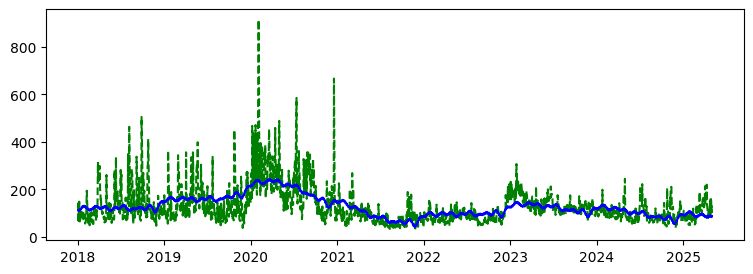

RSI


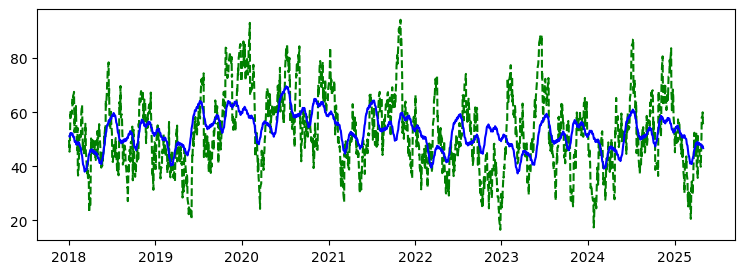

MACD


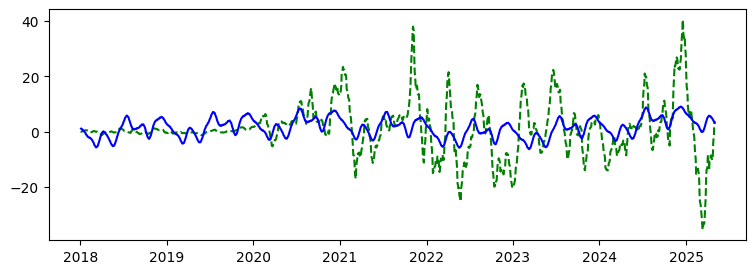

BB_High


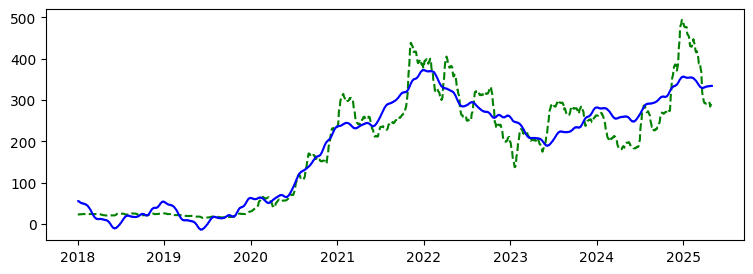

BB_Low


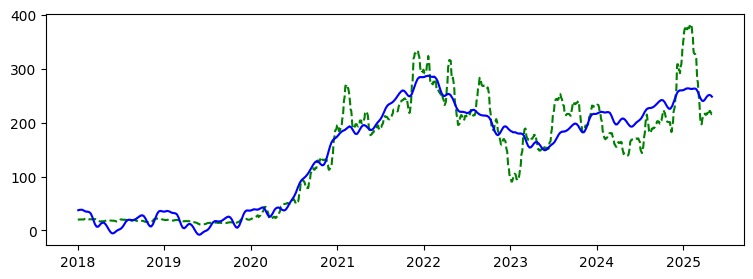

SMA_20


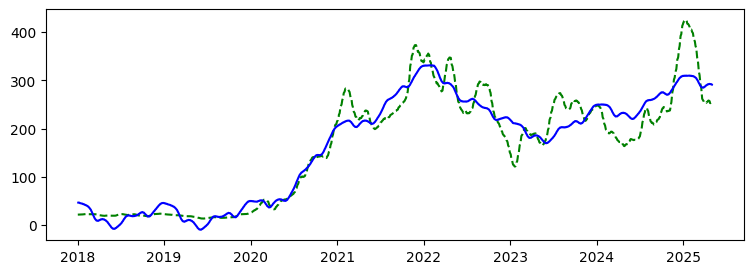

EMA_9_of_MACD


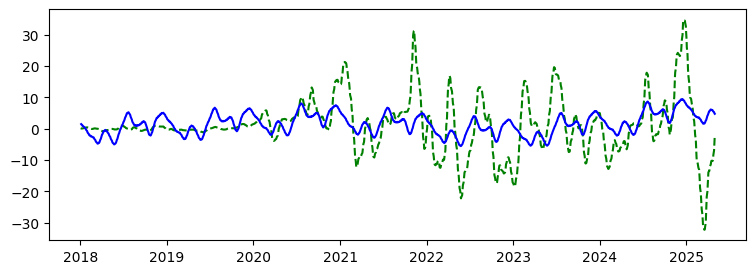

MA_30


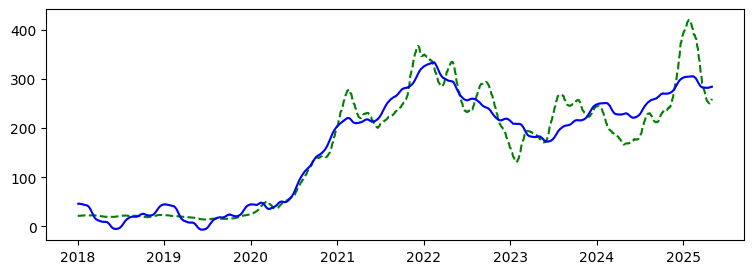

sp500_close


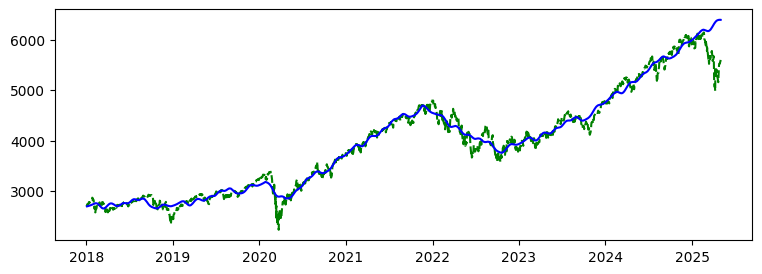

sp500_volume


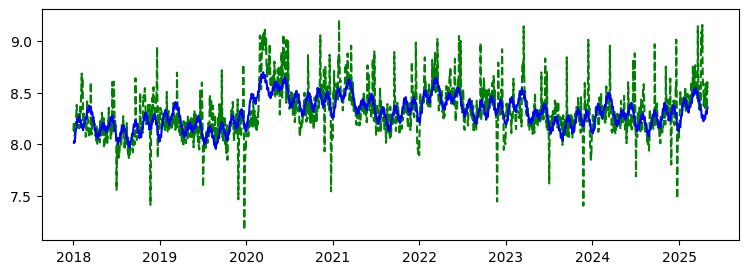

nasdaq_close


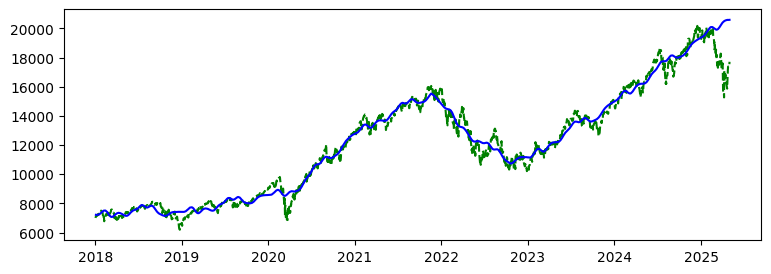

nasdaq_volume


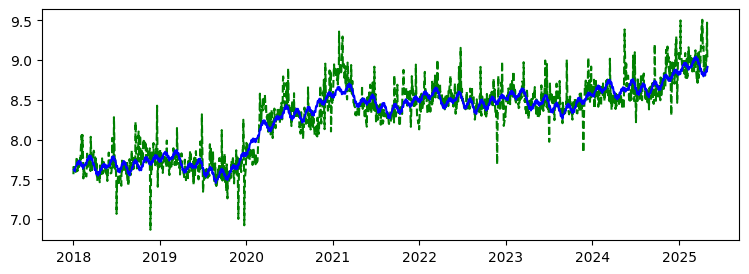

vix_close


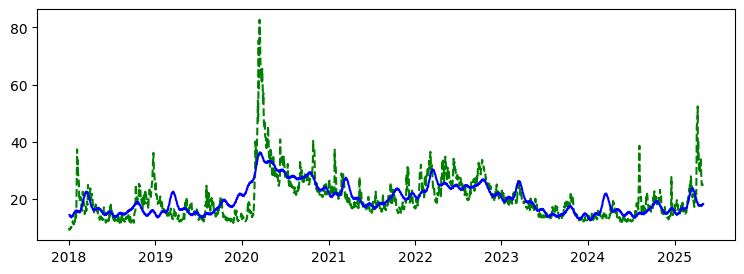

aapl_close


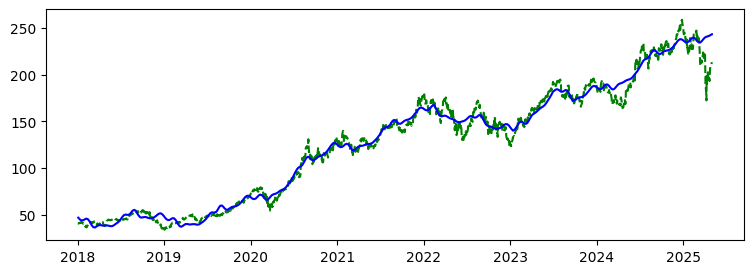

aapl_volume


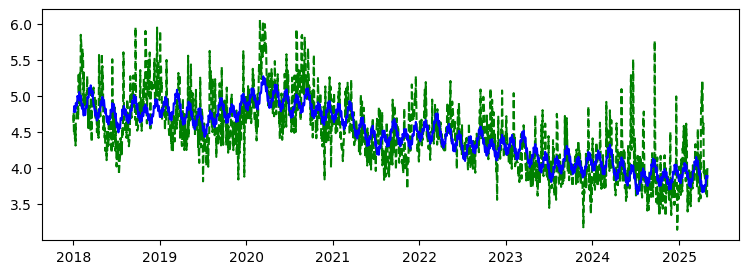

nvda_close


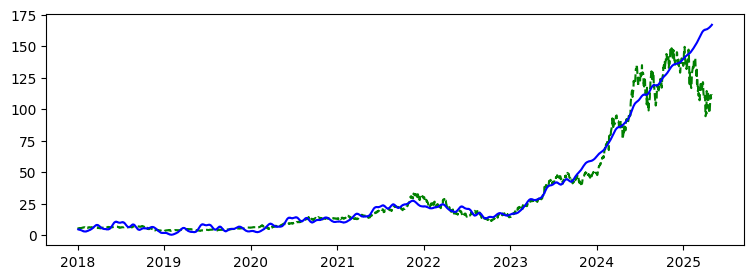

nvda_volume


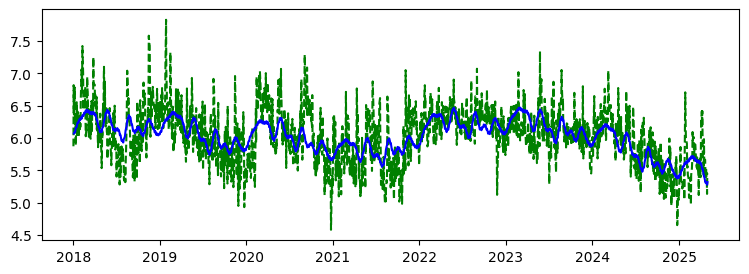

msft_close


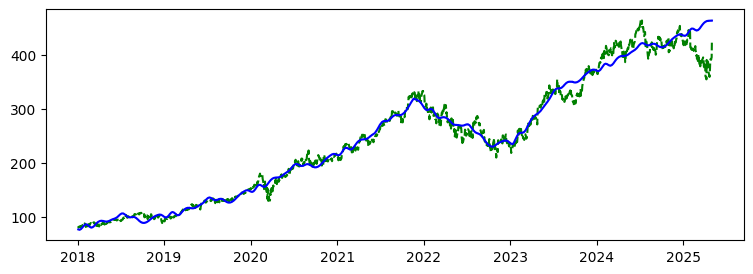

msft_volume


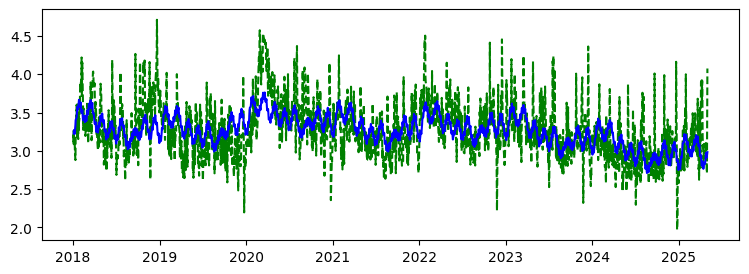

cpi


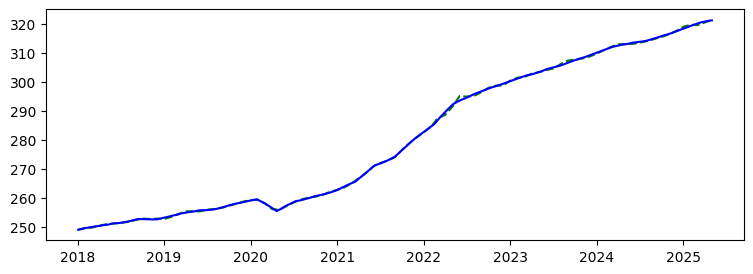

unemployment_rate


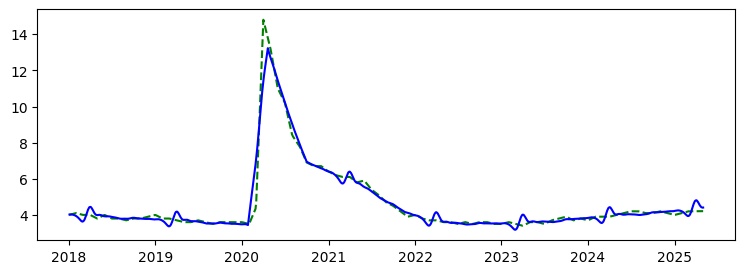

interest_rate


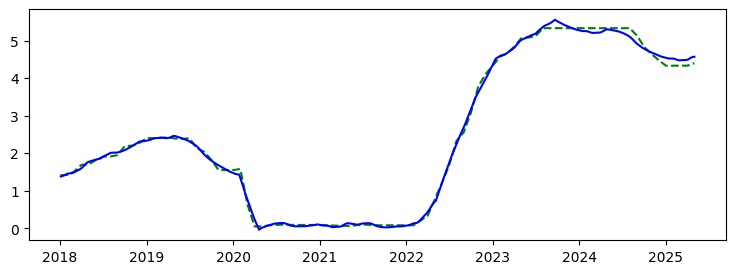

umcsent


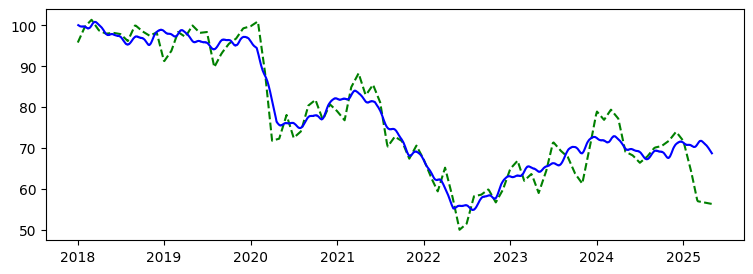

gdp_growth


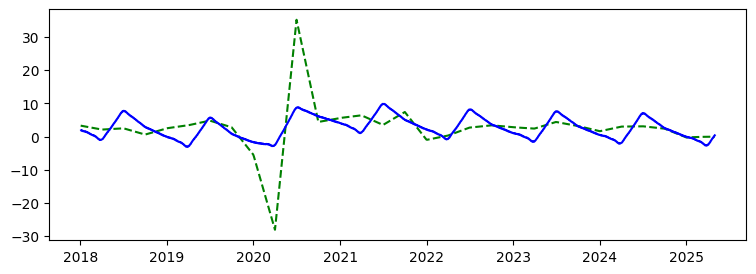

mortgage_rate


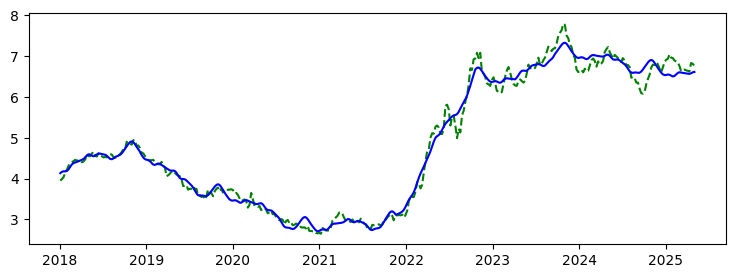

SentimentScore


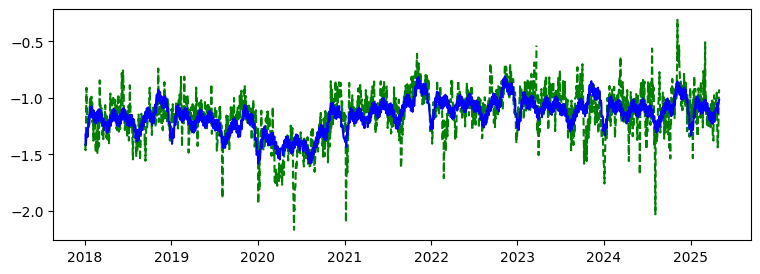

In [9]:
### PLOTTING forecast results with future exogenous variables ###
split_date = split_dt
df1 = forecast[forecast['ds'] >= split_date].copy(deep=True)

df['y_moving_avg'] = df['y'].rolling(window=30).mean()
df2 = df[df['ds'] >= split_date].copy(deep=True)

fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(df2['ds'], df2['y'],     label='Actual',    color='blue',   marker='o', markersize=5)
plt.plot(df2['ds'], df2['y_moving_avg'], label='Moving-Average(30)',    color='red',   marker='o', markersize=5)
plt.plot(df1['ds'], df1['preds'],  label='Predicted', color='orange', marker='v', markersize=5)
plt.legend()
plt.show()


### Calculate Performance Scores for the test set ###
actual_values = df2['y'].values
predicted_values = df_results['preds'].values

mape_score, rmse_score, mae_score = calculate_performance_scores(actual_values, predicted_values)
print(f"MAPE Score: {mape_score*100.0:.2f}%")
print(f"RMSE Score: {rmse_score:.2f}")
print(f"MAE  Score: {mae_score:.2f}")

# Plot exogenous variables trends
for exo_var_ in exo_vars:
    print(exo_var_)
    fig, ax = plt.subplots(figsize=(9, 3))
    plt.plot(df['ds'], df[exo_var_], label='CPI', color='green', linestyle='--')
    plt.plot(df_exo_vars_forecast['ds'], df_exo_vars_forecast[exo_var_], label='CPI', color='blue', linestyle='-')
    plt.show()

### Make real forecast for real future dates/months

In [10]:
# Now we gonna make real predictions for future unknown dates
df, exo_vars = preprocess_data(stock_data, 
                               stocks_additional_features=stocks_indicator_features, 
                               sticker=stock_sticker)

# get market data (SP500, NASDAQ, VIX)
df_market = clean_market_data(sp500_data, nasdaq_data, vix_data)
df = df.merge(df_market, on='ds', how='left')
# add market data columns to exogeneous variables
df_market_cols = df_market.columns.tolist()
df_market_cols.remove('ds')  # Remove 'ds' from the list of market columns
exo_vars.extend(df_market_cols) 

# get tech stocks data (AAPL, NVDA, MSFT)
df_tech = clean_tech_stocks_data(aapl_data, nvda_data, msft_data)
df = df.merge(df_tech, on='ds', how='left')
# add market data columns to exogeneous variables
df_tech_cols = df_tech.columns.tolist()
df_tech_cols.remove('ds')  # Remove 'ds' from the list of market columns
exo_vars.extend(df_tech_cols)

# get earning dates (might be helpfull for training/predictions - Right now, not used)
df_earnings, eps_cols = get_earnings_dates(sticker=stock_sticker)
df = df.merge(df_earnings, on='ds', how='left')

# get federal reserve data
df, exo_vars = get_federal_reserve_data(df, exo_vars, start_date=start_dt)

# get daily news sentiment data
df_news_sentiment, exo_vars = extract_historical_news_sentiment(exo_vars, folder_path="gdelt_news_sentiment")
df = df.merge(df_news_sentiment, on='ds', how='left')

print("using exogeneous features:", exo_vars)

# create train dataset which basically entire dataset of the stock
df_train = df.copy(deep=True)

# train prophet and xgb models
eps_cols = []
prophet_model = train_prophet_model(df_train, exo_vars)
forecast = make_prophet_forecast(df, prophet_model)
df_residuals = create_residuals(df_train, forecast, exo_vars, eps_cols)
xgb_model = train_xgb_model(df_residuals, exo_vars, eps_cols)

# generate forecast for exogeneous in future dates (beyond today date!)
df_exo_vars_forecast = generate_future_exogeneous_vars_forecasts(
                                df_residuals, 
                                exo_vars, lag_vars=['y_lag1','y_lag2'],
                                start_fc_date=real_fc_start_dt, 
                                end_fc_date=real_fc_end_dt
                        )

# Now we can use the trained models to predict future stock prices beyond today date
# starting from 'real_fc_start_dt' to 'real_fc_end_dt' which can be specified in inputs.yml
df_results, forecast_historical = predict_with_forecasted_exo_vars(
                                        df_exo_vars_forecast,
                                        prophet_model, xgb_model, 
                                        exo_vars, eps_cols, lag_vars=['y_lag1','y_lag2'],
                                        start_fc_dt=real_fc_start_dt,
                                        end_fc_dt=real_fc_end_dt,
                                    )

08:28:27 - cmdstanpy - INFO - Chain [1] start processing


using exogeneous features: ['high_value', 'low_value', 'open_value', 'volume_value', 'RSI', 'MACD', 'BB_High', 'BB_Low', 'SMA_20', 'EMA_9_of_MACD', 'MA_30', 'sp500_close', 'sp500_volume', 'nasdaq_close', 'nasdaq_volume', 'vix_close', 'aapl_close', 'aapl_volume', 'nvda_close', 'nvda_volume', 'msft_close', 'msft_volume', 'cpi', 'unemployment_rate', 'interest_rate', 'umcsent', 'gdp_growth', 'mortgage_rate', 'SentimentScore']


08:28:27 - cmdstanpy - INFO - Chain [1] done processing
08:28:28 - cmdstanpy - INFO - Chain [1] start processing


high_value


08:28:28 - cmdstanpy - INFO - Chain [1] done processing
08:28:28 - cmdstanpy - INFO - Chain [1] start processing


low_value


08:28:28 - cmdstanpy - INFO - Chain [1] done processing
08:28:29 - cmdstanpy - INFO - Chain [1] start processing


open_value


08:28:29 - cmdstanpy - INFO - Chain [1] done processing
08:28:29 - cmdstanpy - INFO - Chain [1] start processing


volume_value


08:28:29 - cmdstanpy - INFO - Chain [1] done processing
08:28:29 - cmdstanpy - INFO - Chain [1] start processing
08:28:30 - cmdstanpy - INFO - Chain [1] done processing


RSI


08:28:30 - cmdstanpy - INFO - Chain [1] start processing
08:28:30 - cmdstanpy - INFO - Chain [1] done processing


MACD


08:28:30 - cmdstanpy - INFO - Chain [1] start processing


BB_High


08:28:30 - cmdstanpy - INFO - Chain [1] done processing
08:28:31 - cmdstanpy - INFO - Chain [1] start processing


BB_Low


08:28:31 - cmdstanpy - INFO - Chain [1] done processing
08:28:31 - cmdstanpy - INFO - Chain [1] start processing


SMA_20


08:28:31 - cmdstanpy - INFO - Chain [1] done processing
08:28:31 - cmdstanpy - INFO - Chain [1] start processing
08:28:32 - cmdstanpy - INFO - Chain [1] done processing


EMA_9_of_MACD


08:28:32 - cmdstanpy - INFO - Chain [1] start processing
08:28:32 - cmdstanpy - INFO - Chain [1] done processing


MA_30


08:28:32 - cmdstanpy - INFO - Chain [1] start processing


sp500_close


08:28:32 - cmdstanpy - INFO - Chain [1] done processing
08:28:33 - cmdstanpy - INFO - Chain [1] start processing


sp500_volume


08:28:33 - cmdstanpy - INFO - Chain [1] done processing
08:28:33 - cmdstanpy - INFO - Chain [1] start processing


nasdaq_close


08:28:33 - cmdstanpy - INFO - Chain [1] done processing
08:28:34 - cmdstanpy - INFO - Chain [1] start processing


nasdaq_volume


08:28:34 - cmdstanpy - INFO - Chain [1] done processing
08:28:34 - cmdstanpy - INFO - Chain [1] start processing


vix_close


08:28:35 - cmdstanpy - INFO - Chain [1] done processing
08:28:35 - cmdstanpy - INFO - Chain [1] start processing


aapl_close


08:28:35 - cmdstanpy - INFO - Chain [1] done processing
08:28:35 - cmdstanpy - INFO - Chain [1] start processing


aapl_volume


08:28:35 - cmdstanpy - INFO - Chain [1] done processing
08:28:36 - cmdstanpy - INFO - Chain [1] start processing


nvda_close


08:28:36 - cmdstanpy - INFO - Chain [1] done processing
08:28:36 - cmdstanpy - INFO - Chain [1] start processing


nvda_volume


08:28:36 - cmdstanpy - INFO - Chain [1] done processing
08:28:37 - cmdstanpy - INFO - Chain [1] start processing


msft_close


08:28:37 - cmdstanpy - INFO - Chain [1] done processing
08:28:37 - cmdstanpy - INFO - Chain [1] start processing
08:28:37 - cmdstanpy - INFO - Chain [1] done processing


msft_volume


08:28:38 - cmdstanpy - INFO - Chain [1] start processing


cpi


08:28:38 - cmdstanpy - INFO - Chain [1] done processing
08:28:39 - cmdstanpy - INFO - Chain [1] start processing


unemployment_rate


08:28:39 - cmdstanpy - INFO - Chain [1] done processing
08:28:39 - cmdstanpy - INFO - Chain [1] start processing


interest_rate


08:28:40 - cmdstanpy - INFO - Chain [1] done processing
08:28:40 - cmdstanpy - INFO - Chain [1] start processing


umcsent


08:28:41 - cmdstanpy - INFO - Chain [1] done processing
08:28:41 - cmdstanpy - INFO - Chain [1] start processing
08:28:41 - cmdstanpy - INFO - Chain [1] done processing


gdp_growth


08:28:41 - cmdstanpy - INFO - Chain [1] start processing


mortgage_rate


08:28:42 - cmdstanpy - INFO - Chain [1] done processing
08:28:42 - cmdstanpy - INFO - Chain [1] start processing


SentimentScore


08:28:42 - cmdstanpy - INFO - Chain [1] done processing
08:28:42 - cmdstanpy - INFO - Chain [1] start processing


y_lag1


08:28:42 - cmdstanpy - INFO - Chain [1] done processing
08:28:43 - cmdstanpy - INFO - Chain [1] start processing


y_lag2


08:28:43 - cmdstanpy - INFO - Chain [1] done processing


(75, 34)
(76, 29)
['high_value', 'low_value', 'open_value', 'volume_value', 'RSI', 'MACD', 'BB_High', 'BB_Low', 'SMA_20', 'EMA_9_of_MACD', 'MA_30', 'sp500_close', 'sp500_volume', 'nasdaq_close', 'nasdaq_volume', 'vix_close', 'aapl_close', 'aapl_volume', 'nvda_close', 'nvda_volume', 'msft_close', 'msft_volume', 'cpi', 'unemployment_rate', 'interest_rate', 'umcsent', 'gdp_growth', 'mortgage_rate', 'SentimentScore']


ValueError: Length of values (76) does not match length of index (75)

In [ ]:
### PLOTTING FINAL RESULTS ###
df1 = forecast_historical.copy(deep=True)
df1.rename(columns={'yhat': 'preds'}, inplace=True)
df1 = pd.concat([df1, df_results], axis=0, ignore_index=True)
df1   = df1[df1['ds'] < real_fc_start_dt].copy(deep=True)

fig, ax = plt.subplots(figsize=(14, 4))
plt.plot(df['ds'],         df['y'],             label='Actual',           color='blue', marker='v', markersize=2)
plt.plot(df_results['ds'], df_results['preds'], label='Predicted Trend',  color='orange', marker='v', markersize=2)
plt.plot(df1['ds'],        df1['preds'],        label='Historical Trend', color='red', marker='v', markersize=2)
# Plot preds_upper and preds_lower
plt.plot(df_results['ds'], df_results['preds_upper'], color='green', linestyle='--')
plt.plot(df_results['ds'], df_results['preds_lower'], color='green', linestyle='--')

# Shade the region between preds_upper and preds_lower
plt.fill_between(df_results['ds'], df_results['preds_upper'], df_results['preds_lower'], color='gray', alpha=0.2, label='Confidence Interval')
plt.title(f'{stock_sticker} Stock Price Trend Prediction')
plt.legend()
plt.xlim(pd.to_datetime('2024-03-01'), pd.to_datetime(real_fc_end_dt))
# plt.ylim([150, 450])

# Save the plot
# fig.savefig(f'./figures/past_predictions/{stock_sticker}_predictions_on_04_29_2025.png', dpi=300, bbox_inches='tight')

In [ ]:
df_train.tail()